In [1]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import math
import multiprocessing as mp
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history
from Area2_analysis.lr_funcs import angle_between, process_train_test, gaussian_filter1d_oneside, comp_cc,xcorr
from Area2_analysis.lr_funcs import get_sses_pred, get_sses_mean, nans, fit_and_predict, sub_and_predict, pred_with_new_weights
matplotlib.rc('font', size=18)

2024-08-15 11:10:06.581374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# PyTorch basics - Linear Regression from scratch

In [ ]:
# https://www.kaggle.com/code/aakashns/pytorch-basics-linear-regression-from-scratch

In [ ]:
import torch
import numpy as np
# Create tensors.
x = torch.tensor(3.)
w = torch.tensor(4., requires_grad=True)
b = torch.tensor(5., requires_grad=True)
print(x)
print(w)
print(b)

tensor(3.)
tensor(4., requires_grad=True)
tensor(5., requires_grad=True)


In [ ]:
y = w * x + b
print(y)
# What makes PyTorch special, is that we can automatically compute the derivative of y 
# w.r.t. the tensors that have requires_grad set to True i.e. w and b.
y.backward()
print('dy/dw:', w.grad)
print('dy/db:', b.grad)

tensor(17., grad_fn=<AddBackward0>)
dy/dw: tensor(3.)
dy/db: tensor(1.)


In [ ]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')
inputs.shape

(5, 3)

In [ ]:
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype='float32')
targets.shape

(5, 2)

In [ ]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
print(inputs)
print(targets)
targets.shape

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


torch.Size([5, 2])

In [ ]:
# Weights and biases
w = torch.randn(2, 3, requires_grad=True)
b = torch.randn(2, requires_grad=True)
print(w)
print(b)

tensor([[-3.1442,  0.7235,  0.6307],
        [-1.3352, -0.2037,  0.6353]], requires_grad=True)
tensor([ 0.9002, -0.1825], requires_grad=True)


In [ ]:
# Define the model
def model(x):
    return x @ w.t() + b
# Generate predictions
preds = model(inputs)
print(preds)

tensor([[-153.0286,  -83.9826],
        [-181.1852,  -98.9532],
        [-139.1108, -106.7947],
        [-265.3580, -121.6254],
        [-102.4413,  -67.3974]], grad_fn=<AddBackward0>)


In [ ]:
# Compare with targets
print(targets)
# Because we've started with random weights and biases, the model does not a very good job of predicting the target varaibles.

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


In [ ]:
# We can compare the predictions with the actual targets, using the following method:

# Calculate the difference between the two matrices (preds and targets).
# Square all elements of the difference matrix to remove negative values.
# Calculate the average of the elements in the resulting matrix.
# The result is a single number, known as the mean squared error (MSE).
# MSE loss
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()

In [ ]:
# Compute loss
loss = mse(preds, targets)
print(loss)

tensor(48493.5312, grad_fn=<DivBackward0>)


In [ ]:
# Compute Gradients
# With PyTorch, we can automatically compute the gradient or derivative of the loss w.r.t. to the weights and biases, because they have requires_grad set to True.
loss.backward()

In [ ]:
# The gradients are stored in the .grad property of the respective tensors.
# Gradients for weights
print(w)
print(w.grad)

tensor([[-3.1442,  0.7235,  0.6307],
        [-1.3352, -0.2037,  0.6353]], requires_grad=True)
tensor([[-21011.9102, -20748.5625, -13150.3281],
        [-15867.9639, -16952.0488, -10448.6611]])


In [ ]:
# Gradients for bias
print(b)
print(b.grad)

tensor([ 0.9002, -0.1825], requires_grad=True)
tensor([-244.4248, -187.7506])


In [ ]:
# A key insight from calculus is that the gradient indicates the rate of change of the loss, or the slope of the loss function w.r.t. the weights and biases.

# If a gradient element is postive,
# increasing the element's value slightly will increase the loss.
# decreasing the element's value slightly will decrease the loss.

# If a gradient element is negative,
# increasing the element's value slightly will decrease the loss.
# decreasing the element's value slightly will increase the loss.

In [ ]:
# Finally, we'll reset the gradients to zero before moving forward, because PyTorch accumulates gradients.

w.grad.zero_()
b.grad.zero_()
print(w.grad)
print(b.grad)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([0., 0.])


In [ ]:
# Adjust weights and biases using gradient descent¶
# We'll reduce the loss and improve our model using the gradient descent algorithm, which has the following steps:

# 1. Generate predictions
# 2. Calculate the loss
# 3. Compute gradients w.r.t the weights and biases
# 4. Adjust the weights by subtracting a small quantity proportional to the gradient
# 5. Reset the gradients to zero


In [ ]:
# Generate predictions
preds = model(inputs)
print(preds)

tensor([[-153.0286,  -83.9826],
        [-181.1852,  -98.9532],
        [-139.1108, -106.7947],
        [-265.3580, -121.6254],
        [-102.4413,  -67.3974]], grad_fn=<AddBackward0>)


In [ ]:
# Calculate the loss
loss = mse(preds, targets)
print(loss)

tensor(48493.5312, grad_fn=<DivBackward0>)


In [ ]:
# Compute gradients
loss.backward()

In [ ]:
# Adjust weights & reset gradients

# Context-manager that disables gradient calculation.
# Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). 
# It will reduce memory consumption for computations that would otherwise have requires_grad=True.

with torch.no_grad():     
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5
    w.grad.zero_()
    b.grad.zero_()

In [ ]:
print(w)

tensor([[-2.9340,  0.9310,  0.7622],
        [-1.1765, -0.0342,  0.7397]], requires_grad=True)


In [ ]:
# With the new weights and biases, the model should have a lower loss.
# Calculate loss
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

tensor(33074.8672, grad_fn=<DivBackward0>)


In [ ]:
# Train for 100 epochs
for i in range(100):
    preds = model(inputs)
    loss = mse(preds, targets)
    loss.backward()
    with torch.no_grad():
        w -= w.grad * 1e-5
        b -= b.grad * 1e-5
        w.grad.zero_()
        b.grad.zero_()

In [ ]:
# Calculate loss
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

tensor(361.8480, grad_fn=<DivBackward0>)


In [ ]:
# Print predictions
preds

tensor([[ 48.6877,  69.5983],
        [ 79.4654, 102.4080],
        [138.5597, 130.1483],
        [-28.7815,  33.2752],
        [126.4301, 124.3096]], grad_fn=<AddBackward0>)

In [ ]:
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])

In [ ]:
# Linear Regression Model using PyTorch built-ins
# Let's re-implement the same model using some built-in functions and classes from PyTorch.

import torch.nn as nn
print(inputs)
print(targets)

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


In [ ]:
# Dataset and DataLoader
# We'll create a TensorDataset, which allows access to rows from inputs and targets as tuples. 
# We'll also create a DataLoader, to split the data into batches while training. It also provides other utilities like shuffling and sampling
from torch.utils.data import TensorDataset, DataLoader
# Define dataset
train_ds = TensorDataset(inputs, targets)
train_ds[0:3]


(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.]]),
 tensor([[ 56.,  70.],
         [ 81., 101.],
         [119., 133.]]))

In [ ]:
# Define data loader
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
next(iter(train_dl))

[tensor([[ 91.,  88.,  64.],
         [ 87., 134.,  58.],
         [102.,  43.,  37.],
         [ 73.,  67.,  43.],
         [ 69.,  96.,  70.]]),
 tensor([[ 81., 101.],
         [119., 133.],
         [ 22.,  37.],
         [ 56.,  70.],
         [103., 119.]])]

In [ ]:
# nn.Linear
# Instead of initializing the weights & biases manually, we can define the model using nn.Linear.

# Define model
model = nn.Linear(3, 2)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[ 0.1722, -0.2093,  0.1528],
        [-0.1223,  0.0828, -0.1237]], requires_grad=True)
Parameter containing:
tensor([ 0.0862, -0.3900], requires_grad=True)


In [ ]:
# Optimizer
# Instead of manually manipulating the weights & biases using gradients, we can use the optimizer optim.SGD.

# Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

In [ ]:
# Loss Function
# Instead of defining a loss function manually, we can use the built-in loss function mse_loss.

# Import nn.functional
import torch.nn.functional as F
# Define loss function
loss_fn = F.mse_loss

loss = loss_fn(model(inputs), targets)
print(loss)

tensor(9114.1113, grad_fn=<MseLossBackward0>)


In [ ]:
# Train the model
# We are ready to train the model now. We can define a utility function fit which trains the model for a given number of epochs.

# Define a utility function to train the model
def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            # Generate predictions
            pred = model(xb)
            loss = loss_fn(pred, yb)
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss: ', loss_fn(model(inputs), targets))

In [ ]:
# Train the model for 100 epochs
fit(100, model, loss_fn, opt)

Training loss:  tensor(184.1529, grad_fn=<MseLossBackward0>)


In [ ]:
# Generate predictions
preds = model(inputs)
preds

tensor([[ 62.2068,  73.6111],
        [ 84.5149,  98.3901],
        [105.3390, 132.8344],
        [ 50.1888,  56.1276],
        [ 88.9668, 103.9419]], grad_fn=<AddmmBackward0>)

In [ ]:
# Compare with targets
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])

In [ ]:
# Bonus: Feedfoward Neural Network¶
# Conceptually, you think of feedforward neural networks as two or more linear regression models stacked on top of one another with a non-linear activation function applied between them.

class SimpleNet(nn.Module):
    # Initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(3, 3)
        self.act1 = nn.ReLU() # Activation function
        self.linear2 = nn.Linear(3, 2)
    
    # Perform the computation
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        return x

In [ ]:
model = SimpleNet()
opt = torch.optim.SGD(model.parameters(), 1e-5)
loss_fn = F.mse_loss

In [ ]:
fit(100, model, loss_fn, opt)


Training loss:  tensor(132.4305, grad_fn=<MseLossBackward0>)


# linear model

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
# Define dataset
import torch.nn.functional as F
import torch.nn.utils.parametrize as P
from tqdm import tqdm
from sklearn.metrics import r2_score


In [3]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')
inputs.shape

(5, 3)

In [4]:
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype='float32')
targets.shape

(5, 2)

In [ ]:
# inputs = torch.from_numpy(inputs)
# targets = torch.from_numpy(targets)

In [ ]:
# train_ds = TensorDataset(inputs, targets)
# # Define data loader
# batch_size = 5
# train_dl = DataLoader(train_ds, batch_size, shuffle=True)
# next(iter(train_dl))

In [ ]:
# # Define a utility function to train the model
# def fit(num_epochs, model, loss_fn, opt):
#     for epoch in range(num_epochs):
#         for xb,yb in train_dl:
#             # Generate predictions
#             pred = model(xb)
#             loss = loss_fn(pred, yb)
#             # Perform gradient descent
#             loss.backward()
#             opt.step()
#             opt.zero_grad()
#     print('Training loss: ', loss_fn(model(inputs), targets))

In [ ]:
# class LinearModel(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super().__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.linear = nn.Linear(input_dim, output_dim)
        
#     def forward(self, x):
#         output = self.linear(x)
#         return output

In [ ]:
# class LDGF(object):
#     def __init__(self, n_epochs=500, learning_rate = 0.01, init = None):
#         self.n_epochs = n_epochs
#         self.init = init
#         self.learning_rate = learning_rate
#     def fit_transform(self, X, Y):
#         model = LinearModel(X.shape[1], Y.shape[1])
            
#         X = torch.tensor(X,dtype=torch.float)
#         y = torch.tensor(Y,dtype=torch.float)

#         model.eval()
#         y_pred = model(X)
#         loss_fn = F.mse_loss
#         loss = loss_fn(y_pred, y)
#         losses=np.zeros(self.n_epochs+1)
#         losses[0]=loss.item()

#         optimizer = torch.optim.Adam(model.parameters(), lr = self.learning_rate)
#         model.train()
#         for epoch in tqdm(range(self.n_epochs), position=0, leave=True):
#             optimizer.zero_grad()
#             # Forward pass
#             y_pred = model(X)
#             # Compute Loss
#             loss = loss_fn(y_pred, y)
#             losses[epoch+1]=loss.item()
#             # Backward pass
#             loss.backward()
#             optimizer.step()
        
#         # Include attributes as part of self
#         self.model=model
#         self.losses=losses
#         self.params={}
#         self.params['weight']=model.linear.state_dict()['weight'].detach().numpy()
#         self.params['bias']=model.linear.state_dict()['bias'].detach().numpy()
#         self.r2_score=r2_score(y,y_pred.detach().numpy())
#         return y_pred.detach().numpy()

In [262]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim, weight_init, b_init):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Linear(input_dim, output_dim, bias = True)
        self.linear.weight = torch.nn.Parameter(torch.tensor(weight_init, dtype=torch.float))
        self.linear.bias = torch.nn.Parameter(torch.tensor(b_init, dtype=torch.float))
        
    def forward(self, x):
        output = self.linear(x)
        return output

In [263]:
from sklearn.linear_model import LinearRegression
class LDGF(object):
    def __init__(self, n_epochs=3000, learning_rate = None, init = None):
        self.n_epochs = n_epochs
        self.init = init
        self.learning_rate = learning_rate
    def fit_transform(self, X, y):
        if self.init is None:
            weight_init = np.random.randn(X.shape[1], y.shape[1]).T
            b_init = np.zeros(y.shape[1])
        elif self.init == 'linear_regression':
            reg = LinearRegression().fit(X, y)
            weight_init = reg.coef_
            b_init = reg.intercept_

        if self.learning_rate == None:
            if self.init == 'linear_regression':
                self.learning_rate = 0.001
            elif self.init is None:
                self.learning_rate = 0.01
            
        model = LinearModel(X.shape[1], y.shape[1], weight_init, b_init)
            
        X = torch.tensor(X,dtype=torch.float)
        y = torch.tensor(y,dtype=torch.float)

        model.eval()
        y_pred = model(X)
        loss_fn = F.mse_loss
        loss = loss_fn(y_pred, y)
        losses=np.zeros(self.n_epochs+1)
        losses[0]=loss.item()

        optimizer = torch.optim.Adam(model.parameters(), lr = self.learning_rate)
        model.train()
        for epoch in tqdm(range(self.n_epochs), position=0, leave=True):
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(X)
            # Compute Loss
            loss = loss_fn(y_pred, y)
            losses[epoch+1]=loss.item()
            # Backward pass
            loss.backward()
            optimizer.step()
        
        # Include attributes as part of self
        self.model=model
        self.losses=losses
        self.params={}
        self.params['weight']=model.linear.weight.detach().numpy()
        self.params['bias']=model.linear.bias.detach().numpy()
        self.r2_score=r2_score(y,y_pred.detach().numpy())
        return y_pred.detach().numpy()

In [264]:
ldgf=LDGF()
y_pred=ldgf.fit_transform(X=inputs, y=targets)
print(y_pred)
y_true = targets
print(y_true)

100%|██████████| 3000/3000 [00:00<00:00, 3483.85it/s]

[[ 57.27134   70.20066 ]
 [ 82.08204  100.73799 ]
 [118.81406  132.9762  ]
 [ 21.101822  37.028435]
 [101.807    119.12064 ]]
[[ 56.  70.]
 [ 81. 101.]
 [119. 133.]
 [ 22.  37.]
 [103. 119.]]


loss 0.5176504850387573
r2 0.9995628492484461
weight [[-0.40280315  0.85155     0.675182  ]
 [-0.2972817   0.79428643  0.9146885 ]]
bias [ 0.58926535 -0.64661443]


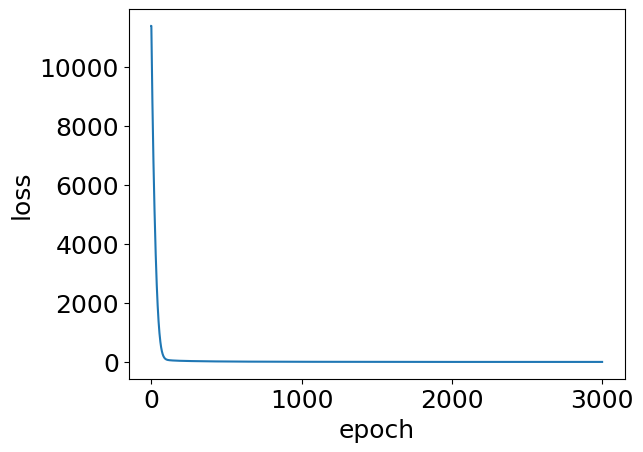

In [265]:
import matplotlib.pyplot as plt
plt.plot(ldgf.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
print('loss',ldgf.losses[-1])
print('r2',ldgf.r2_score)
print('weight',ldgf.params['weight'])
print('bias',ldgf.params['bias'])

In [266]:
y_pred

array([[ 57.27134 ,  70.20066 ],
       [ 82.08204 , 100.73799 ],
       [118.81406 , 132.9762  ],
       [ 21.101822,  37.028435],
       [101.807   , 119.12064 ]], dtype=float32)

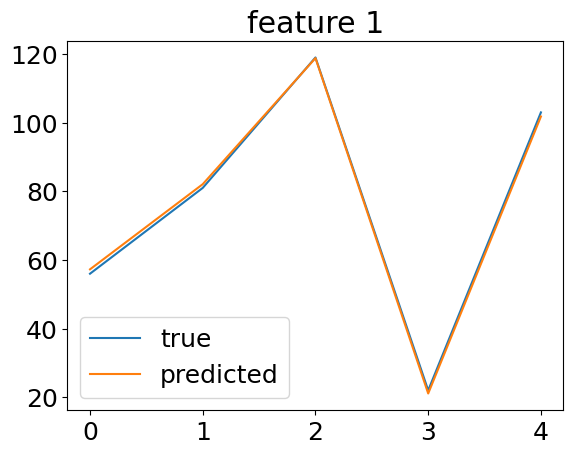

Text(0.5, 1.0, 'feature 2')

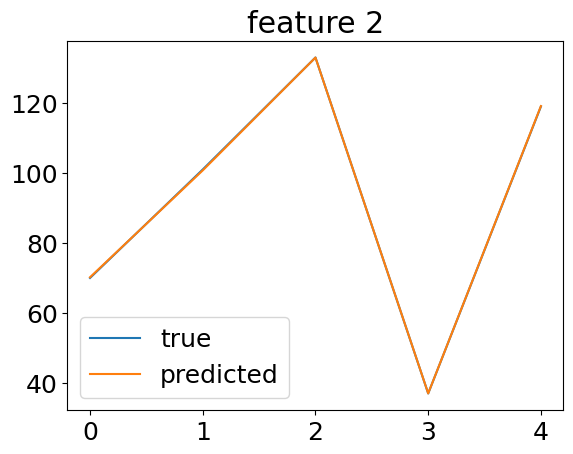

In [267]:
plt.plot(y_true[:,0],label='true')
plt.plot(y_pred[:,0],label='predicted')
plt.legend()
plt.title('feature 1')
plt.show()
plt.plot(y_true[:,1],label='true')
plt.plot(y_pred[:,1],label='predicted')
plt.legend()
plt.title('feature 2')


## Simulate data

In [268]:
np.random.seed(0)

In [269]:
T= 200 #Time
N_neurons = 10
N_features = 2
X0 = np.random.randn(T,N_neurons)
w0 = np.random.randn(N_neurons, N_features)
print(X0.shape)
print(w0.shape)
b0 = np.random.randn(N_features)
Y0 = X0 @ w0 + b0
print(Y0.shape)

(200, 10)
(10, 2)
(200, 2)


Text(0.5, 1.0, 'Simulated features')

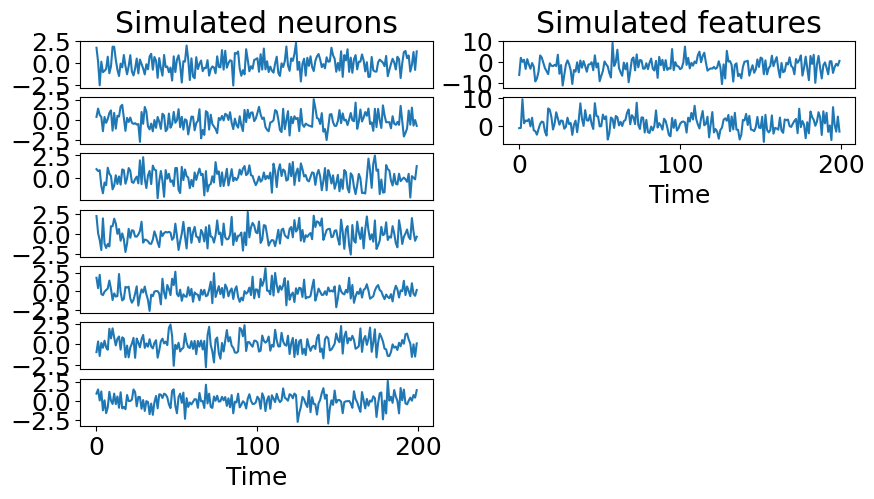

In [270]:
plt.figure(figsize=(10,5))
N_plot_neurons = 7
for i in range(N_plot_neurons):
    
    #Plot ground truth
    plt.subplot(N_plot_neurons,2,2*i+1)
    plt.plot((X0)[:,i]) 
    
    # plt.yticks([])
    if i<N_plot_neurons-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')
for i in range(N_features):
    plt.subplot(N_plot_neurons,2,2*i+2)
    plt.plot((Y0)[:,i]) 
    # plt.yticks([])    
    if i<N_features-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

plt.subplot(N_plot_neurons,2,1)
plt.title('Simulated neurons')

plt.subplot(N_plot_neurons,2,2)
plt.title('Simulated features')

In [275]:
# ldgf=LDGF(init='linear_regression')
ldgf=LDGF()

y_pred=ldgf.fit_transform(X=X0, y=Y0)
print(y_pred)
y_true = Y0
print(y_true)

100%|██████████| 3000/3000 [00:01<00:00, 2926.33it/s]

[[-6.23752975e+00 -8.36948812e-01]
 [ 2.00270844e+00 -7.53758609e-01]
 [ 7.40720034e-02  9.44424152e+00]
 [ 1.06769621e+00  8.98361623e-01]
 [-3.33258104e+00  1.89074373e+00]
 [ 1.37408698e+00  1.66412544e+00]
 [-1.25469232e+00  2.37181211e+00]
 [-3.25218058e+00 -2.10791528e-01]
 [-5.25106430e-01  2.85954857e+00]
 [-2.16165757e+00 -1.56027842e+00]
 [-9.33410072e+00 -1.92099142e+00]
 [-7.90010643e+00 -3.15745091e+00]
 [-4.69780016e+00 -1.14135838e+00]
 [ 3.12654781e+00  6.49775803e-01]
 [ 2.14204216e+00  1.49524570e+00]
 [-3.68666053e-01  1.28588629e+00]
 [-2.96803570e+00 -2.06778312e+00]
 [-4.43664312e+00 -3.46262693e+00]
 [-5.85357904e+00  6.16552496e+00]
 [-6.20966792e-01  5.67686462e+00]
 [-1.81658101e+00  3.11503148e+00]
 [-1.98865271e+00 -1.31203270e+00]
 [-1.37591743e+00  7.94016838e-01]
 [-1.96814311e+00  4.80432320e+00]
 [ 3.47809982e+00  2.59732938e+00]
 [-5.63146639e+00  3.91060174e-01]
 [-1.48073876e+00  1.88248038e+00]
 [-1.13045321e+01  1.73619580e+00]
 [-6.30686474e+00 -1

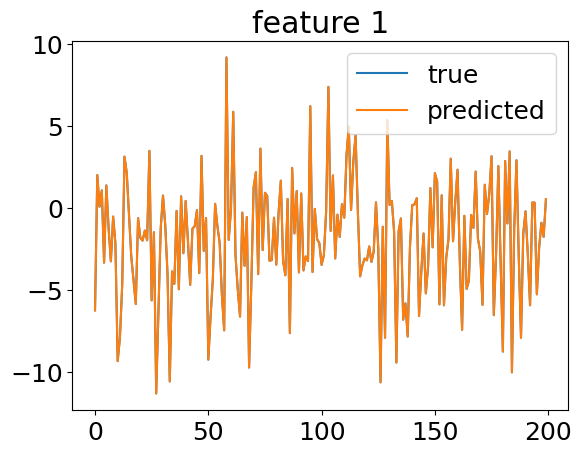

Text(0.5, 1.0, 'feature 2')

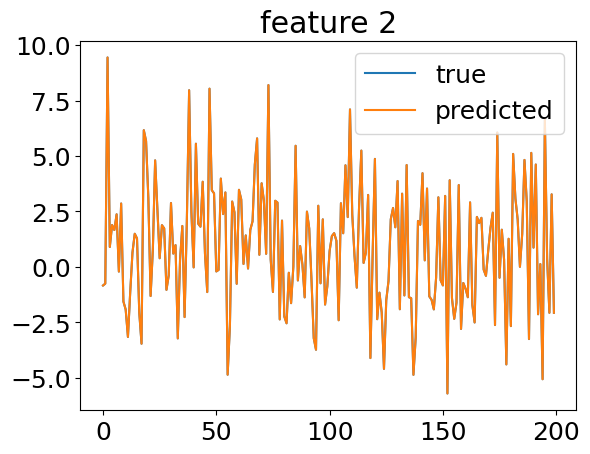

In [276]:
plt.plot(y_true[:,0],label='true')
plt.plot(y_pred[:,0],label='predicted')
plt.legend()
plt.title('feature 1')
plt.show()
plt.plot(y_true[:,1],label='true')
plt.plot(y_pred[:,1],label='predicted')
plt.legend()
plt.title('feature 2')


In [277]:
print('true weight',w0)
print('true bias',b0)

true weight [[-1.53292105 -1.71197016]
 [ 0.04613506 -0.95837448]
 [-0.08081161 -0.70385904]
 [-0.7707843  -0.48084534]
 [ 0.70358555  0.92914515]
 [ 0.37117255 -0.98982255]
 [ 0.64363128  0.68889667]
 [ 0.2746472  -0.60362044]
 [ 0.70885958  0.42281857]
 [-3.11685659  0.64445203]]
true bias [-1.91374267  0.66356158]


loss 2.646830454464122e-12
r2 0.9999999999997142
pred weight [[-1.5329206  -1.7119685 ]
 [ 0.04613511 -0.9583744 ]
 [-0.08081158 -0.70385855]
 [-0.7707842  -0.48084548]
 [ 0.70358574  0.92914534]
 [ 0.37117243 -0.9898231 ]
 [ 0.64363146  0.6888964 ]
 [ 0.27464718 -0.6036211 ]
 [ 0.70885956  0.42281866]
 [-3.1168551   0.64445215]]
pred bias [-1.913742   0.6635619]


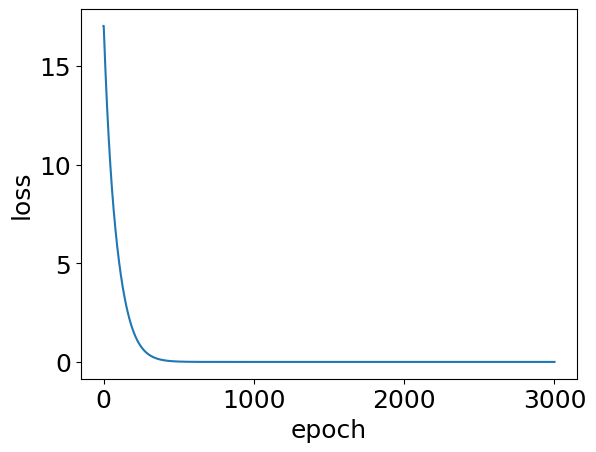

In [278]:
plt.plot(ldgf.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
print('loss',ldgf.losses[-1])
print('r2',ldgf.r2_score)
print('pred weight',ldgf.params['weight'].T)
print('pred bias',ldgf.params['bias'])

## Simulate data + add filter

In [291]:
def gaussian_filter(x, sigma):
    return np.exp(-0.5*((x)/sigma)**2)

In [294]:
filter_length = 41
x_range = np.arange(-filter_length//2+1, filter_length//2+1)
sigmas = [2,5]
gaussian_filter_list = [gaussian_filter(x_range,sigmas[j]) for j in range(N_features)]

Y0_with_filter = np.stack([np.convolve(Y0[:,j], filter, mode='same') for j, filter in enumerate(gaussian_filter_list)]).T
print(Y0_with_filter.shape)

(200, 2)


In [296]:
filter = gaussian_filter(x_range, sigma=2)
X0_with_filter = np.stack([np.convolve(X0[:,j], filter,mode='same') for j in range(X0.shape[1])]).T
print(X0_with_filter.shape)

(200, 10)


Text(0.5, 1.0, 'Simulated features, filtered')

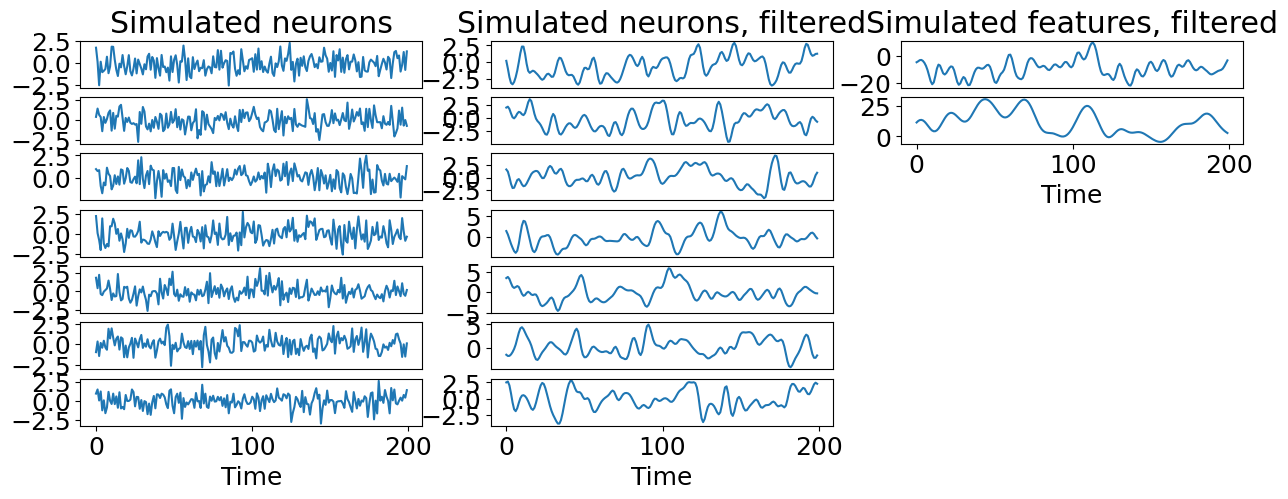

In [325]:
plt.figure(figsize=(15,5))
N_plot_neurons = 7
for i in range(N_plot_neurons):
    
    #Plot ground truth
    plt.subplot(N_plot_neurons,3,3*i+1)
    plt.plot((X0)[:,i]) 
    
    # plt.yticks([])
    if i<N_plot_neurons-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

for i in range(N_plot_neurons):
    
    #Plot ground truth
    plt.subplot(N_plot_neurons,3,3*i+2)
    plt.plot((X0_with_filter)[:,i]) 
    
    # plt.yticks([])
    if i<N_plot_neurons-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

# for i in range(N_features):
    # plt.subplot(N_plot_neurons,3,3*i+2)
    # plt.plot((Y0)[:,i]) 
    # # plt.yticks([])    
    # if i<N_features-1:
    #     plt.xticks([])
    # else:
    #     plt.xlabel('Time')

for i in range(N_features):
    plt.subplot(N_plot_neurons,3,3*i+3)
    plt.plot((Y0_with_filter)[:,i]) 
    # plt.yticks([])    
    if i<N_features-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

plt.subplot(N_plot_neurons,3,1)
plt.title('Simulated neurons')


plt.subplot(N_plot_neurons,3,2)
plt.title('Simulated neurons, filtered')

# plt.subplot(N_plot_neurons,3,2)
# plt.title('Simulated features')

plt.subplot(N_plot_neurons,3,3)
plt.title('Simulated features, filtered')

In [326]:
ldgf=LDGF(init='linear_regression')
# ldgf=LDGF()

# y_pred=ldgf.fit_transform(X=X0, y=Y0)
# y_pred=ldgf.fit_transform(X=X0, y=Y0_with_filter)
y_pred=ldgf.fit_transform(X=X0_with_filter, y=Y0_with_filter)


print(y_pred)
# y_true = Y0
y_true = Y0_with_filter
print(y_true)

100%|██████████| 3000/3000 [00:00<00:00, 3381.49it/s]

[[ -7.697937    13.122617  ]
 [ -5.294775    16.73964   ]
 [ -3.38758     19.679798  ]
 [ -2.779007    20.62219   ]
 [ -3.442573    19.664745  ]
 [ -4.968134    17.82063   ]
 [ -7.2186966   15.675606  ]
 [-10.418916    12.905257  ]
 [-14.628155     9.008255  ]
 [-18.951305     4.3427253 ]
 [-21.35247      0.36069298]
 [-19.954498    -1.3306341 ]
 [-15.019944    -0.27037334]
 [ -9.342313     2.4602413 ]
 [ -6.213463     5.251381  ]
 [ -6.8941703    7.5324707 ]
 [ -9.966271    10.159399  ]
 [-12.8338585   13.879833  ]
 [-13.742714    17.713043  ]
 [-12.655111    19.714642  ]
 [-10.622195    19.386475  ]
 [ -8.688626    18.35812   ]
 [ -7.55054     18.351519  ]
 [ -7.9135323   19.314976  ]
 [-10.44202     19.977276  ]
 [-14.89055     19.448902  ]
 [-19.488844    17.762287  ]
 [-21.802898    15.4801235 ]
 [-20.737911    13.292141  ]
 [-17.772188    11.592266  ]
 [-15.870583    10.145311  ]
 [-16.86712      8.485517  ]
 [-19.875608     6.7628646 ]
 [-22.271564     5.8902903 ]
 [-22.097197  

In [327]:
r2_score(y_true, y_pred)

0.885195607196419

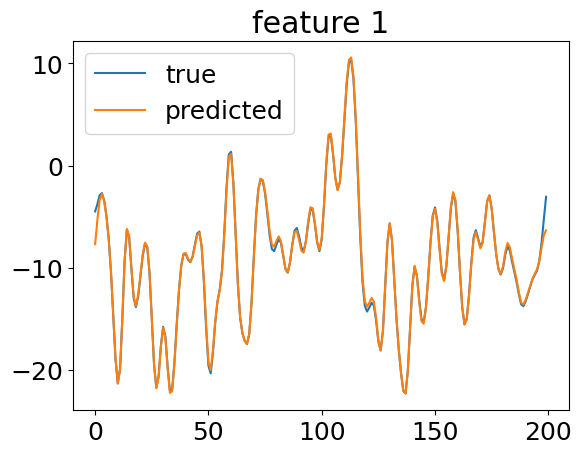

Text(0.5, 1.0, 'feature 2')

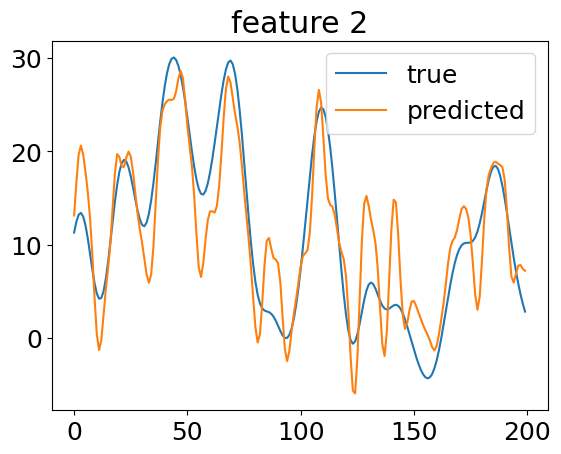

In [328]:
plt.plot(y_true[:,0],label='true')
plt.plot(y_pred[:,0],label='predicted')
plt.legend()
plt.title('feature 1')
plt.show()
plt.plot(y_true[:,1],label='true')
plt.plot(y_pred[:,1],label='predicted')
plt.legend()
plt.title('feature 2')


In [118]:
print('true weight',w0)
print('true bias',b0)

true weight [[ 1.51150747 -0.42920391]
 [-0.28149013 -0.29865051]
 [ 0.97136288  1.16593415]
 [-0.18450572  0.00658518]
 [ 0.50654829  0.19578279]
 [ 0.78521598  1.09925082]
 [-0.63815879 -0.22581109]
 [-0.05189087 -0.49103588]
 [-2.24599002 -0.79851087]
 [-0.80939372  0.24043134]]
true bias [0.43769578 0.30216343]


loss 48.62967300415039
r2 0.2332856618001672
pred weight [[-1.1433054  -1.7601234 ]
 [-0.09401717 -1.5713185 ]
 [ 0.23115276 -0.2737189 ]
 [-0.776746   -1.1029054 ]
 [ 1.3094767   1.1401082 ]
 [ 0.5429345  -0.7237291 ]
 [ 0.99719393  0.9796996 ]
 [ 0.30393025 -1.3661634 ]
 [ 1.1330309   0.2527783 ]
 [-2.5958354   1.2541279 ]]
pred bias [-9.405997 10.889363]


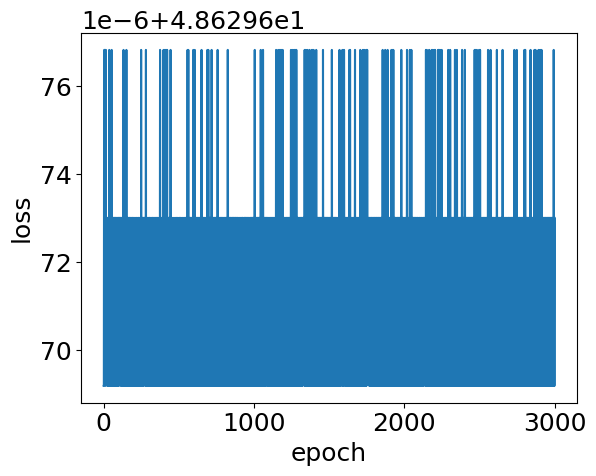

In [317]:
plt.plot(ldgf.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
print('loss',ldgf.losses[-1])
print('r2',ldgf.r2_score)
print('pred weight',ldgf.params['weight'].T)
print('pred bias',ldgf.params['bias'])

# filter model

In [329]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim, weight_init, b_init, filter_length):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Linear(input_dim, output_dim, bias = True)
        self.linear.weight = torch.nn.Parameter(torch.tensor(weight_init, dtype=torch.float))
        self.linear.bias = torch.nn.Parameter(torch.tensor(b_init, dtype=torch.float))
        self.filter_length = filter_length
        self.sigmas = torch.nn.Parameter(torch.ones(self.output_dim))
        self._filter_range = torch.arange(-self.filter_length//2+1, self.filter_length//2+1)

    def _gaussian_filter(self, x, sigma):
        return torch.exp(-0.5*((x)/sigma)**2)
    
    def decode_filter(self, x):
        linear_output = x @ self.linear.weight.T + self.linear.bias
        gaussian_filter_list = [self._gaussian_filter(self._filter_range,self.sigmas[j]).reshape(1,1,-1)
                                for j in range(self.output_dim)]
        filter_output = torch.stack([F.conv1d(linear_output[:,j].reshape(1,1,-1), filter, padding='same') 
                                     for j, filter in enumerate(gaussian_filter_list)]).squeeze().T
        return filter_output    

    def forward(self, x):
        output = self.decode_filter(x)
        return output
    def plottable_filters(self):
        return self._filter_range.detach().numpy(), [self._gaussian_filter(self._filter_range, self.sigmas[i]).detach().numpy() for i in range(self.output_dim)]

In [330]:
from sklearn.linear_model import LinearRegression
class LDGF(object):
    def __init__(self, n_epochs=3000, learning_rate = None, init = None, filter_length = 41):
        self.n_epochs = n_epochs
        self.init = init
        self.learning_rate = learning_rate
        self.filter_length = filter_length
    def fit_transform(self, X, y):
        if self.init is None:
            weight_init = np.random.randn(X.shape[1], y.shape[1]).T
            b_init = np.zeros(y.shape[1])
        elif self.init == 'linear_regression':
            reg = LinearRegression().fit(X, y)
            weight_init = reg.coef_
            b_init = reg.intercept_

        if self.learning_rate == None:
            self.learning_rate = 0.01
            
        model = LinearModel(X.shape[1], y.shape[1], weight_init, b_init, self.filter_length)
            
        X = torch.tensor(X,dtype=torch.float)
        y = torch.tensor(y,dtype=torch.float)

        model.eval()
        y_pred = model(X)
        loss_fn = F.mse_loss
        loss = loss_fn(y_pred, y)
        losses=np.zeros(self.n_epochs+1)
        losses[0]=loss.item()

        optimizer = torch.optim.Adam(model.parameters(), lr = self.learning_rate)
        model.train()
        for epoch in tqdm(range(self.n_epochs), position=0, leave=True):
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(X)
            # Compute Loss
            loss = loss_fn(y_pred, y)
            losses[epoch+1]=loss.item()
            # Backward pass
            loss.backward()
            optimizer.step()
        
        # Include attributes as part of self
        self.model=model
        self.losses=losses
        self.params={}
        self.params['weight']=model.linear.weight.detach().numpy()
        self.params['bias']=model.linear.bias.detach().numpy()
        self.r2_score=r2_score(y,y_pred.detach().numpy())
        return y_pred.detach().numpy()

Text(0.5, 1.0, 'Simulated features, filtered')

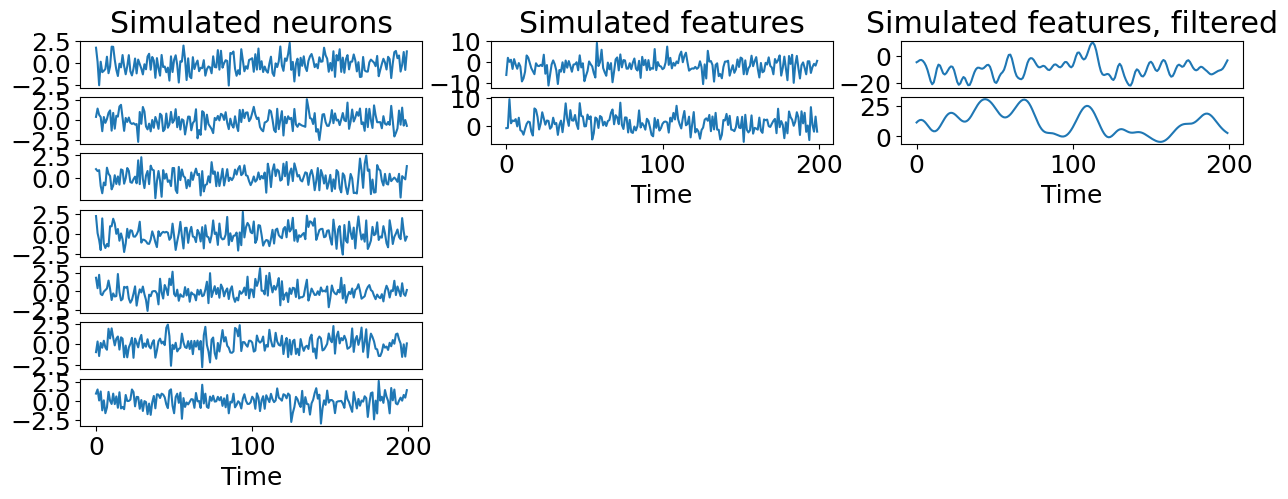

In [331]:
plt.figure(figsize=(15,5))
N_plot_neurons = 7
for i in range(N_plot_neurons):
    
    #Plot ground truth
    plt.subplot(N_plot_neurons,3,3*i+1)
    plt.plot((X0)[:,i]) 
    
    # plt.yticks([])
    if i<N_plot_neurons-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')


for i in range(N_features):
    plt.subplot(N_plot_neurons,3,3*i+2)
    plt.plot((Y0)[:,i]) 
    # plt.yticks([])    
    if i<N_features-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

for i in range(N_features):
    plt.subplot(N_plot_neurons,3,3*i+3)
    plt.plot((Y0_with_filter)[:,i]) 
    # plt.yticks([])    
    if i<N_features-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

plt.subplot(N_plot_neurons,3,1)
plt.title('Simulated neurons')



plt.subplot(N_plot_neurons,3,2)
plt.title('Simulated features')

plt.subplot(N_plot_neurons,3,3)
plt.title('Simulated features, filtered')

In [433]:
filter = gaussian_filter(x_range, sigma=2)
X0_with_filter = np.stack([np.convolve(X0[:,j], filter,mode='same') for j in range(X0.shape[1])]).T
print(X0_with_filter.shape)

(200, 10)


In [440]:
ldgf=LDGF(init='linear_regression',n_epochs=6000)
# ldgf=LDGF()

# y_pred=ldgf.fit_transform(X=X0, y=Y0)
# y_pred=ldgf.fit_transform(X=X0, y=Y0_with_filter)
y_pred=ldgf.fit_transform(X=X0_with_filter, y=Y0_with_filter)


print(y_pred)
# y_true = Y0
y_true = Y0_with_filter
print(y_true)

100%|██████████| 6000/6000 [00:06<00:00, 861.28it/s]

[[ -7.1221285   11.304189  ]
 [ -5.4014144   12.618515  ]
 [ -3.4845333   13.469591  ]
 [ -2.8109808   13.735944  ]
 [ -3.4135094   13.364228  ]
 [ -4.9415894   12.38538   ]
 [ -7.258878    10.916626  ]
 [-10.534192     9.148403  ]
 [-14.751232     7.318389  ]
 [-18.98399      5.6776104 ]
 [-21.268007     4.4547796 ]
 [-19.85058      3.8250673 ]
 [-15.033097     3.8881128 ]
 [ -9.508151     4.657967  ]
 [ -6.433856     6.065408  ]
 [ -7.037769     7.9710455 ]
 [ -9.983092    10.186291  ]
 [-12.778235    12.498552  ]
 [-13.704268    14.696994  ]
 [-12.673571    16.59553   ]
 [-10.669059    18.050611  ]
 [ -8.726695    18.972195  ]
 [ -7.5877967   19.32773   ]
 [ -7.9769473   19.139723  ]
 [-10.512045    18.478628  ]
 [-14.898445    17.452972  ]
 [-19.398296    16.198381  ]
 [-21.682163    14.866677  ]
 [-20.721502    13.615287  ]
 [-17.930645    12.596624  ]
 [-16.127125    11.946852  ]
 [-17.062738    11.773869  ]
 [-19.917974    12.145305  ]
 [-22.209455    13.078432  ]
 [-22.049631  

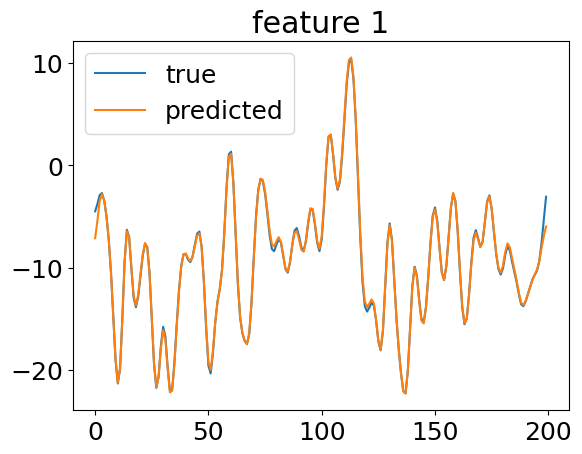

Text(0.5, 1.0, 'feature 2')

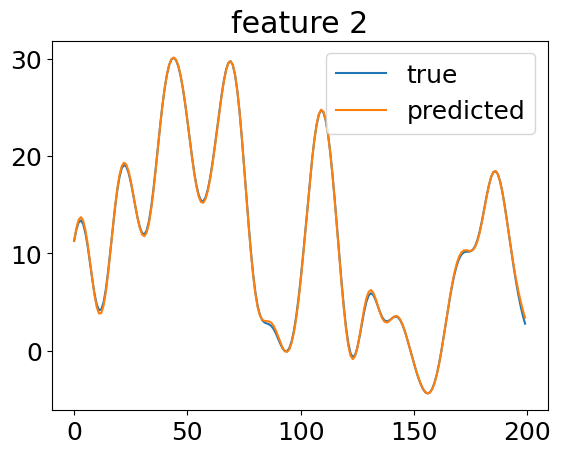

In [441]:
plt.plot(y_true[:,0],label='true')
plt.plot(y_pred[:,0],label='predicted')
plt.legend()
plt.title('feature 1')
plt.show()
plt.plot(y_true[:,1],label='true')
plt.plot(y_pred[:,1],label='predicted')
plt.legend()
plt.title('feature 2')


In [442]:
print('true weight',w0)
print('true bias',b0)

true weight [[-1.53292105 -1.71197016]
 [ 0.04613506 -0.95837448]
 [-0.08081161 -0.70385904]
 [-0.7707843  -0.48084534]
 [ 0.70358555  0.92914515]
 [ 0.37117255 -0.98982255]
 [ 0.64363128  0.68889667]
 [ 0.2746472  -0.60362044]
 [ 0.70885958  0.42281857]
 [-3.11685659  0.64445203]]
true bias [-1.91374267  0.66356158]


loss 0.08249162882566452
r2 0.9980604670437828
pred weight [[-1.3185954  -0.38235912]
 [ 0.07751926 -0.21126924]
 [-0.05085107 -0.15303288]
 [-0.69051236 -0.10812551]
 [ 0.6214029   0.20283213]
 [ 0.2888339  -0.21492466]
 [ 0.6375869   0.14856815]
 [ 0.25367185 -0.1369738 ]
 [ 0.59925747  0.08701435]
 [-2.7326767   0.13831009]]
pred bias [-8.201419   0.7422918]


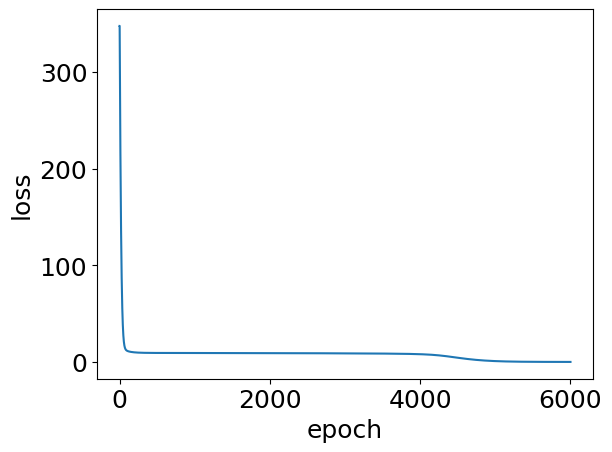

In [443]:
plt.plot(ldgf.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
print('loss',ldgf.losses[-1])
print('r2',ldgf.r2_score)
print('pred weight',ldgf.params['weight'].T)
print('pred bias',ldgf.params['bias'])

In [438]:
x, y = ldgf.model.plottable_filters()

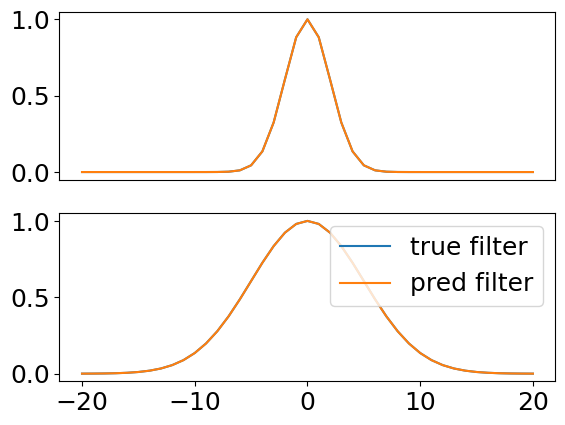

In [439]:
j=0
for i in range(N_features):
    plt.subplot(N_features, 1,i+1)
    plt.plot(x,gaussian_filter_list[i],label='true filter')
    plt.plot(x,y[i],label='pred filter')
    if i < N_features-1:
        plt.xticks([])
    j+=2
plt.legend()